In [2]:
!git clone https://github.com/aubinbnf/Speech-Emotion-Recognition.git
%cd Speech-Emotion-Recognition
# !git branch -r
# !git switch TESS
# !git switch simon
# !git status
# !git pull TESS



Cloning into 'Speech-Emotion-Recognition'...
remote: Enumerating objects: 14379, done.
remote: Counting objects: 100% (1541/1541), done.
remote: Compressing objects: 100% (1497/1497), done.
remote: Total 14379 (delta 42), reused 1530 (delta 36), pack-reused 12838 (from 1)
Receiving objects: 100% (14379/14379), 774.97 MiB | 28.03 MiB/s, done.
Resolving deltas: 100% (302/302), done.
Updating files: 100% (9061/9061), done.
/content/Speech-Emotion-Recognition


In [3]:
%ls
%cd Speech-Emotion-Recognition



sample_data/
[Errno 2] No such file or directory: 'Speech-Emotion-Recognition'
/content
 audio_representations/   CNNBLSTM/           EXTRAS_MODELS/   PARALELLECNN/         VGG/
 CNN/                    'data management'/   LSTM/           'Results and plots'/
[Errno 2] No such file or directory: 'Speech-Emotion-Recognition'
/content/Speech-Emotion-Recognition


Using GPU: /physical_device:GPU:0
Training set: (1712, 224, 224, 3), (1712, 9)
Validation set: (367, 224, 224, 3), (367, 9)
Test set: (368, 224, 224, 3), (368, 9)
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 58s 375ms/step - accuracy: 0.2045 - loss: 2.0840 - val_accuracy: 0.4905 - val_loss: 1.4034
Epoch 2/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 49s 201ms/step - accuracy: 0.4323 - loss: 1.4393 - val_accuracy: 0.5395 - val_loss: 1.1922
Epoch 3/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 195ms/step - accuracy: 0.5542 - loss: 1.1934 - val_accuracy: 0.5123 - val_loss: 1.1679
Epoch 4/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 204ms/step - accuracy: 0.6033 - loss: 1.0565 - val_accuracy: 0.6485 - val_loss: 0.9785
Epoch 5/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 40s 190ms/step - accuracy: 0.6785 - loss: 0.9079 - val_accuracy: 0.6376 - val_loss: 0.9394
Epoch 6/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 24s 229ms/step - accuracy: 0.6635 - loss: 0.8899 - val_accuracy: 0.6512 - val_loss: 0.9268


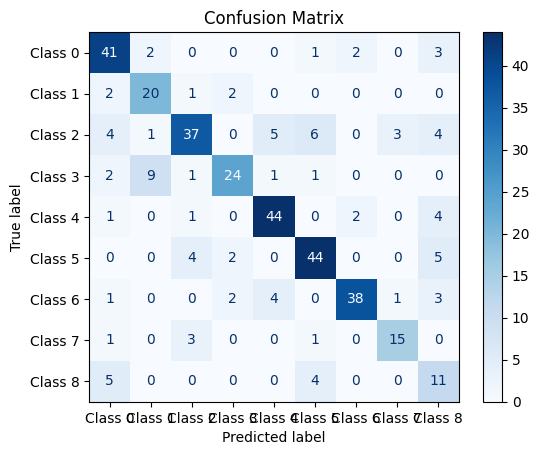

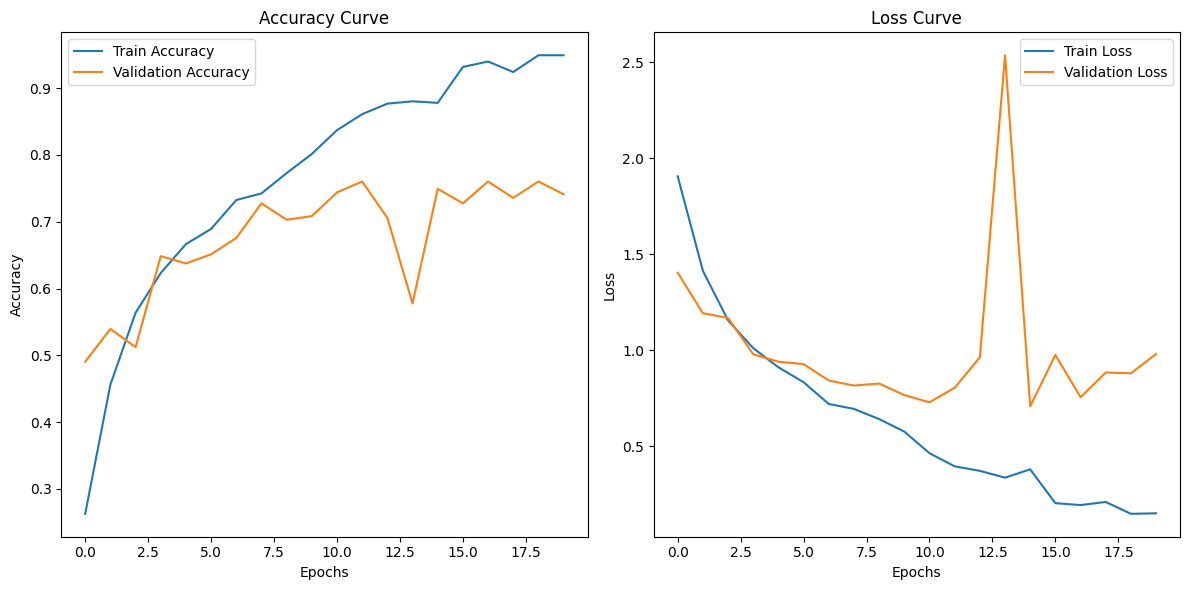

In [4]:
#!/usr/bin/env python3

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ==========================
# GPU CONFIGURATION
# ==========================
# Automatically detect GPU and configure memory growth
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Using GPU:", physical_devices[0].name)
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU found. Using CPU.")

# ==========================
# DATA LOADING AND PREPROCESSING
# ==========================
# Define paths to datasets
# ==========================
# DATA LOADING AND PREPROCESSING
# ==========================
# Define paths to datasets and their respective sampling rates
dataset_dirs = {
    "audio_representations/audio_representations_savee/spectrograms/": 1,
    "audio_representations/audio_representations_Tess/spectrograms/": 0.4,
    "audio_representations/audio_representations_ravdess/spectrograms/": 0.7
}

images, labels = [], []

# Load images and extract labels
for dataset_dir, sampling_rate in dataset_dirs.items():
    all_files = [f for f in os.listdir(dataset_dir) if f.endswith(".png")]
    sampled_files = np.random.choice(all_files, size=int(len(all_files) * sampling_rate), replace=False)

    for file_name in sampled_files:
        file_path = os.path.join(dataset_dir, file_name)
        img = Image.open(file_path).convert("RGB").resize((224, 224))  # Resize to 224x224 for VGG19
        images.append(np.array(img))

        # Extract label from filename (e.g., third part of 'emotion-xx-yy.png')
        parts = file_name.split("-")
        if len(parts) >= 3:
            label_raw = int(parts[2]) - 1  # Convert to 0-based index
        else:
            print(f"Skipping {file_name}: Incorrect format.")
            continue
        labels.append(label_raw)

# Convert to NumPy arrays
images = np.array(images) / 255.0  # Normalize pixel values to [0, 1]
labels = np.array(labels)
num_classes = len(np.unique(labels))  # Number of emotion classes

# One-hot encode the labels
labels_one_hot = to_categorical(labels, num_classes=num_classes)

# Split dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# ==========================
# MODEL DEFINITION
# ==========================
# Load pre-trained VGG19 base
conv_base = VGG19(weights='imagenet', pooling='avg', include_top=False, input_shape=(224, 224, 3))

# Freeze the first 12 layers
for layer in conv_base.layers[:12]:
    layer.trainable = False

# Define the full model
model = Sequential([
    conv_base,
    Dense(256, activation='relu'),  # Custom fully connected layer
    Dropout(0.3),                   # Dropout for regularization
    Dense(num_classes, activation='softmax')  # Output layer for multi-class classification
])

# Compile the model
learning_rate = 5e-5
model.compile(optimizer=optimizers.Adam(learning_rate),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

# ==========================
# MODEL TRAINING
# ==========================
# Train the model with early stopping and checkpointing
# Callbacks
callbacks = [
    ModelCheckpoint(
        "vgg19_model.keras",  # Sauvegarde dans le nouveau format
        monitor="val_accuracy",
        save_best_only=True,
        mode="max"
    ),
    EarlyStopping(
        monitor="val_loss",  # Surveille la perte de validation
        patience=5,          # Nombre d'epochs sans amélioration avant d'arrêter
        restore_best_weights=True  # Restaurer les poids du meilleur modèle
    )
]

# Entraînement
history = model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=40,
    shuffle=True,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)


# ==========================
# EVALUATION AND METRICS
# ==========================
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Generate predictions for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot to class indices
y_true_classes = np.argmax(y_test, axis=1)

# Compute classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=[f"Class {i}" for i in range(num_classes)]))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[f"Class {i}" for i in range(num_classes)])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ==========================
# VISUALIZATIONS
# ==========================
# Plot training history
plt.figure(figsize=(12, 6))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# ==========================
# NOTES
# ==========================
# 1. We added confusion matrix and F1-score for better evaluation of per-class performance.
# 2. The training process saves the best model using ModelCheckpoint.
# 3. Preprocessing steps (resize, normalization, and one-hot encoding) ensure compatibility with VGG19.
# 4. Early stopping and monitoring validation accuracy reduce overfitting risks.


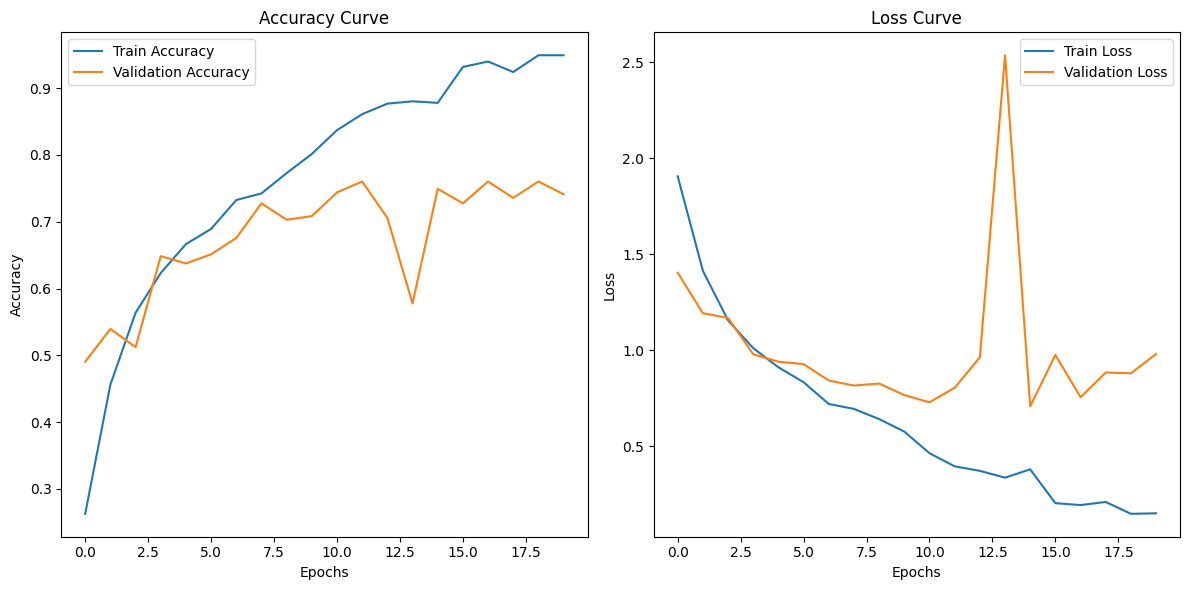

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step
Classification Report:
              precision    recall  f1-score   support

     neutral       0.72      0.84      0.77        49
        calm       0.62      0.80      0.70        25
       happy       0.79      0.62      0.69        60
         sad       0.80      0.63      0.71        38
       angry       0.81      0.85      0.83        52
     fearful       0.77      0.80      0.79        55
     disgust       0.90      0.78      0.84        49
   surprised       0.79      0.75      0.77        20
       other       0.37      0.55      0.44        20

    accuracy                           0.74       368
   macro avg       0.73      0.73      0.73       368
weighted avg       0.76      0.74      0.75       368



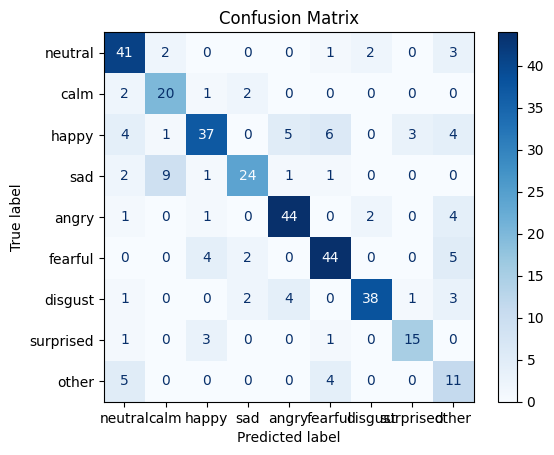

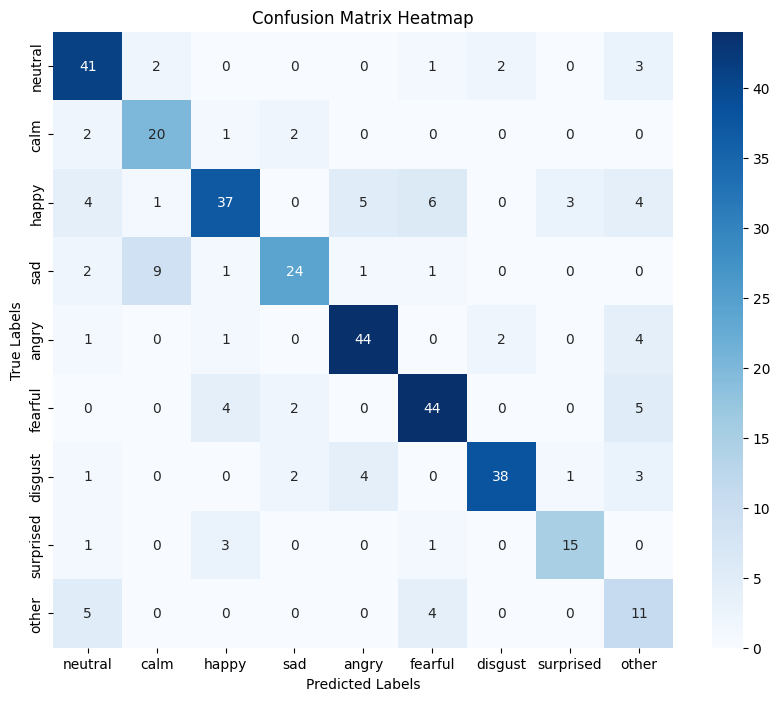

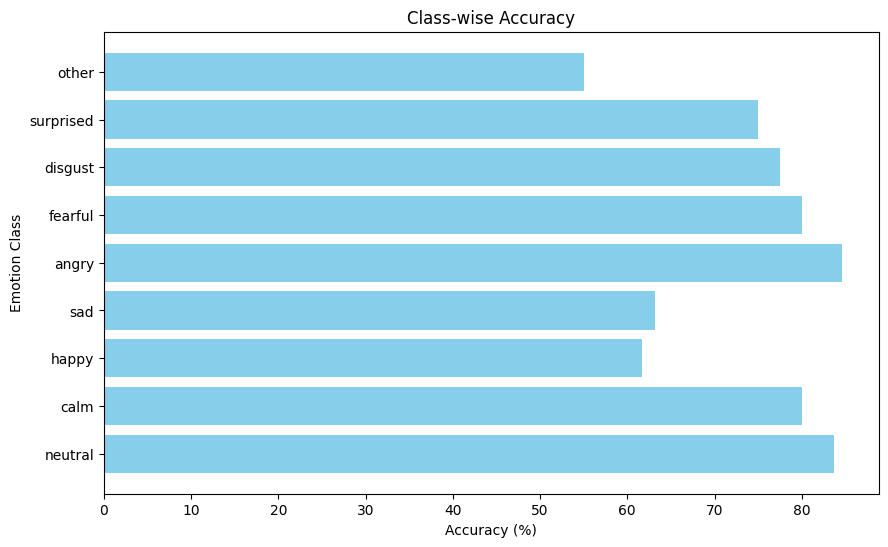

In [7]:
# ==========================
# ADDITIONAL VISUALIZATIONS AND PLOTS
# ==========================
import seaborn as sns

# Emotion labels
emotion_labels = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised",
    "09": "other",  # If there are additional labels
    # Add any other labels as needed...
}
# Plot training history
plt.figure(figsize=(12, 6))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# ==========================
# CONFUSION MATRIX AND CLASSIFICATION REPORT
# ==========================
# Generate predictions for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot to class indices
y_true_classes = np.argmax(y_test, axis=1)

# Compute classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=[emotion_labels[str(i+1).zfill(2)] for i in range(num_classes)]))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[emotion_labels[str(i+1).zfill(2)] for i in range(num_classes)])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ==========================
# ADDITIONAL METRICS PLOTS
# ==========================
# Create a heatmap of the confusion matrix for a more visually appealing plot
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[emotion_labels[str(i+1).zfill(2)] for i in range(num_classes)], yticklabels=[emotion_labels[str(i+1).zfill(2)] for i in range(num_classes)])
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# ==========================
# CLASSWISE ACCURACY PLOT
# ==========================
# Plot class-wise accuracy
class_accuracy = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1) * 100
plt.figure(figsize=(10, 6))
plt.barh([emotion_labels[str(i+1).zfill(2)] for i in range(num_classes)], class_accuracy, color='skyblue')
plt.title("Class-wise Accuracy")
plt.xlabel("Accuracy (%)")
plt.ylabel("Emotion Class")
plt.show()

# ==========================
# NOTES
# ==========================
# 1. The confusion matrix is plotted for a clear visual understanding of true vs predicted labels.
# 2. Classification report is printed to evaluate precision, recall, and F1-score for each emotion class.
# 3. A heatmap of the confusion matrix provides an intuitive understanding of the performance.
# 4. Class-wise accuracy shows how well each emotion class is predicted.


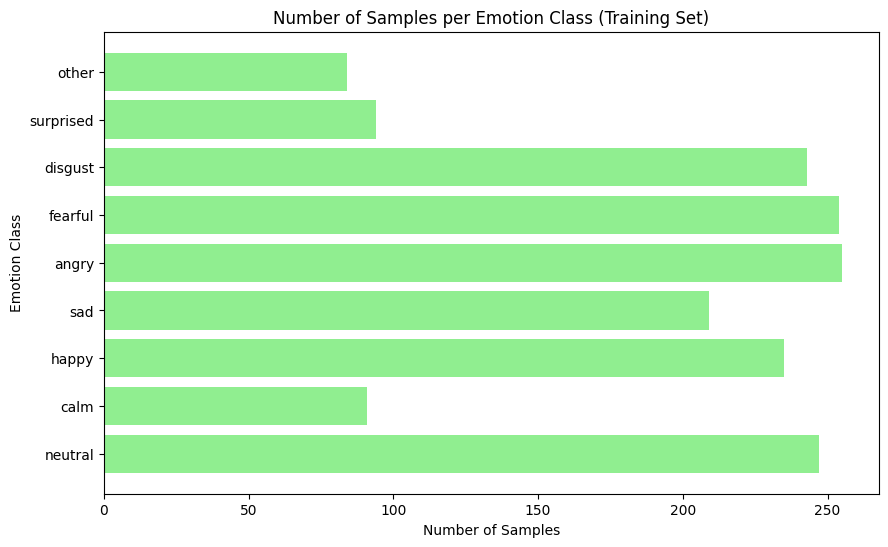

In [8]:
# ==========================
# PLOT NUMBER OF SAMPLES PER CLASS
# ==========================
# Count the number of samples per class in the training set
class_counts = np.sum(y_train, axis=0)

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.barh([emotion_labels[str(i+1).zfill(2)] for i in range(num_classes)], class_counts, color='lightgreen')
plt.title("Number of Samples per Emotion Class (Training Set)")
plt.xlabel("Number of Samples")
plt.ylabel("Emotion Class")
plt.show()


In [10]:
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np

# Define the emotion labels (ensure this matches your class labels)
emotion_labels = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# Function to load and preprocess a sample image
def preprocess_sample_image(image_path):
    # Load image
    img = Image.open(image_path).convert("RGB").resize((224, 224))  # Resize to 224x224 for VGG19
    img_array = np.array(img) / 255.0  # Normalize the pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Function to predict emotion from a sample image
def predict_emotion(image_path, model):
    # Preprocess the image
    img_array = preprocess_sample_image(image_path)

    # Get the model's prediction
    predictions = model.predict(img_array)

    # Get the predicted class
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Get the corresponding emotion label
    emotion = emotion_labels[str(predicted_class + 1).zfill(2)]  # Adjusting index to match the labels
    return emotion

# Load the saved model (ensure that you have the correct path)
model = load_model("vgg19_modelclean.keras")

# Example: test on a sample image (provide the path to your spectrogram image)
image_path = "spectrogram_output.png"  # Change this to your image path
predicted_emotion = predict_emotion(image_path, model)

# Print the predicted emotion
print(f"The predicted emotion for the given spectrogram is: {predicted_emotion}")


ValueError: File not found: filepath=vgg19_modelclean.keras. Please ensure the file is an accessible `.keras` zip file.

In [15]:
from PIL import Image
import numpy as np

# Define the emotion labels (ensure this matches your class labels)
emotion_labels = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# Function to load and preprocess a sample image
def preprocess_sample_image(image_path):
    # Load image
    img = Image.open(image_path).convert("RGB").resize((224, 224))  # Resize to 224x224 for VGG19
    img_array = np.array(img) / 255.0  # Normalize the pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Function to predict emotion from a sample image
def predict_emotion(image_path, model):
    # Preprocess the image
    img_array = preprocess_sample_image(image_path)

    # Get the model's prediction
    predictions = model.predict(img_array)

    # Get the predicted class
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Get the corresponding emotion label
    emotion = emotion_labels[str(predicted_class + 1).zfill(2)]  # Adjusting index to match the labels
    return emotion

# Example: test on a sample image (provide the path to your spectrogram image)
image_path = "/content/output_spectrogram.png"  # Change this to your image path
predicted_emotion = predict_emotion(image_path, model)

# Print the predicted emotion
print(f"The predicted emotion for the given spectrogram is: {predicted_emotion}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
The predicted emotion for the given spectrogram is: sad


In [ ]:
%pwd
%ls

 audio_representations/   CNNBLSTM/           EXTRAS_MODELS/   PARALELLECNN/         VGG/
 CNN/                    'data management'/   LSTM/           'Results and plots'/


Using GPU: /physical_device:GPU:0
Training set: (1512, 224, 224, 3), (1512, 9)
Validation set: (324, 224, 224, 3), (324, 9)
Test set: (324, 224, 224, 3), (324, 9)
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 50s 358ms/step - accuracy: 0.1902 - loss: 2.1053 - val_accuracy: 0.3611 - val_loss: 1.5449
Epoch 2/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 210ms/step - accuracy: 0.4414 - loss: 1.4166 - val_accuracy: 0.7099 - val_loss: 0.8487
Epoch 3/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - accuracy: 0.6775 - loss: 0.8801 - val_accuracy: 0.7222 - val_loss: 0.7740
Epoch 4/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 220ms/step - accuracy: 0.7050 - loss: 0.7951 - val_accuracy: 0.7840 - val_loss: 0.6401
Epoch 5/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 39s 199ms/step - accuracy: 0.7330 - loss: 0.7399 - val_accuracy: 0.7593 - val_loss: 0.6381
Epoch 6/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - accuracy: 0.7613 - loss: 0.6523 - val_accuracy: 0.7716 - val_loss: 0.6164
Epoch 7/40
9

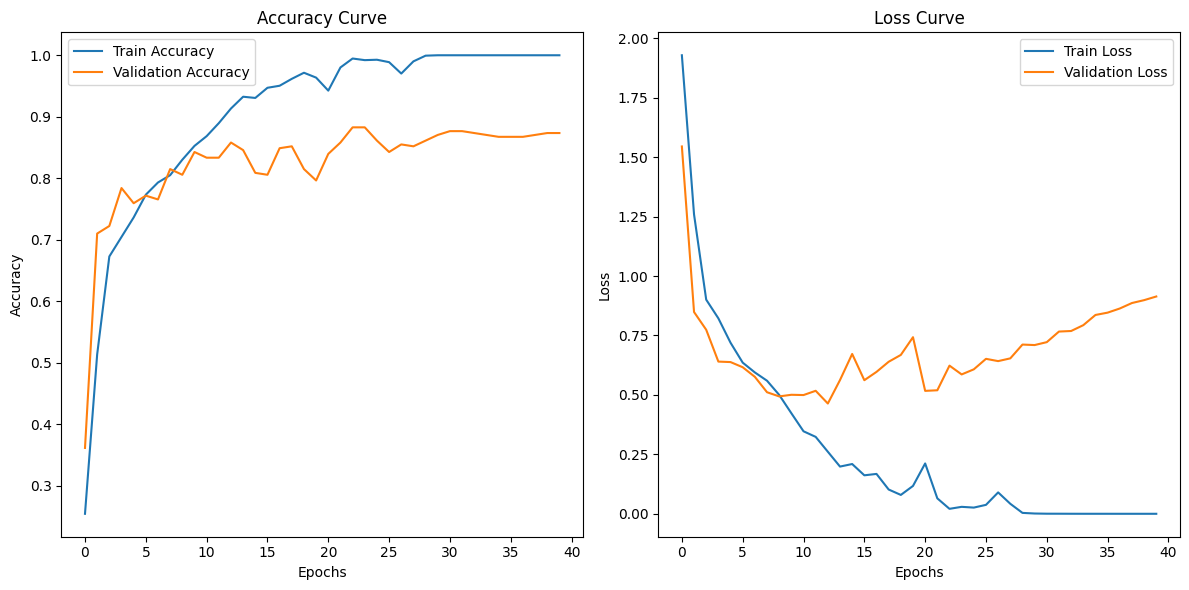

In [ ]:
#!/usr/bin/env python3

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image

# GPU configuration
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Using GPU:", physical_devices[0].name)
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU found. Using CPU.")

# Load spectrograms from multiple datasets
dataset_dirs = [
    "audio_representations/audio_representations_savee/spectrograms/",
    "audio_representations/audio_representations_Tess/spectrograms/",
    "audio_representations/audio_representations_ravdess/spectrograms/"
]

images = []
labels = []

# Sample 70% of the dataset to reduce RAM usage
sampling_rate = 0.5

for dataset_dir in dataset_dirs:
    # Get all image files
    all_files = [f for f in os.listdir(dataset_dir) if f.endswith(".png")]

    # Randomly sample files
    sampled_files = np.random.choice(
        all_files,
        size=int(len(all_files) * sampling_rate),
        replace=False
    )

    for file_name in sampled_files:
        file_path = os.path.join(dataset_dir, file_name)

        # Load and resize image
        img = Image.open(file_path).convert("RGB")
        img = img.resize((224, 224))  # VGG19 expects 224x224 input size
        img_array = np.array(img)
        images.append(img_array)

        # Extract label from filename's third value
        parts = file_name.split("-")
        if len(parts) >= 3:
            label_raw = int(parts[2]) - 1  # Adjusting to 0-based indexing
        else:
            print(f"Skipping file {file_name} - not enough parts")
            continue

        labels.append(label_raw)

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize the images
images = images / 255.0

# One-hot encode labels
num_classes = len(np.unique(labels))
labels_one_hot = to_categorical(labels, num_classes=num_classes)

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# VGG19 model setup
img_height, img_width = 224, 224
conv_base = VGG19(weights='imagenet', pooling='avg', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the first 12 layers of VGG19
for layer in conv_base.layers[:12]:
    layer.trainable = False

# Create model
model = models.Sequential([
    conv_base,
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Model compilation
learning_rate = 5e-5
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate), metrics=['accuracy'])

# Training
history = model.fit(X_train, y_train, batch_size=16,
                    epochs=40,
                    shuffle=True,
                    validation_data=(X_val, y_val),
                    callbacks=[ModelCheckpoint("vgg19_multi_dataset.keras", monitor='val_accuracy', save_best_only=True, mode='max')])

# Evaluation
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.save_weights('vgg19_model.weights.h5')


In [ ]:
model.save('vgg19_complete_model.h5')
